In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf

from model import ImageCaptionModel
from decoder import TransformerDecoder, RNNDecoder

from transformers.utils import logging
logging.set_verbosity_error() 

## Exploring the Dataset

In [2]:
## Before this, download the dataset and run preprocessing.py as instructed. 
## This may take like 10 mins, but should only happen once so ok.
## https://www.kaggle.com/datasets/adityajn105/flickr8k?resource=download

with open('../memes900k/data.p', 'rb') as data_file:
    data_dict = pickle.load(data_file)

# As mentioned in the handout, this assignment has 5 captions per image. This block of code 
# expands the image_feature lists to have 5 copies of each image to correspond to each of their captions 
feat_prep = lambda x: np.repeat(np.array(x).reshape(-1, 2048), 50, axis=0)
img_prep  = lambda x: np.repeat(x, 50, axis=0)

## Captions; preprocessed sentences with 20 window size
train_captions  = np.array(data_dict['train_captions']);            print('train_captions:  ', train_captions.shape)
test_captions   = np.array(data_dict['test_captions']);             print('test_captions:   ', test_captions.shape)

## 2048-D resnet embeddings of images.
train_img_feats = feat_prep(data_dict['train_image_features']);     print('\ntrain_img_feats: ', train_img_feats.shape)
test_img_feats  = feat_prep(data_dict['test_image_features']);      print('test_img_feats:  ', test_img_feats.shape)

## Small subset of actual images for visualization purposes. 
## These are just for the first 100 images of each (clones 5 times)
train_images    = img_prep(data_dict['train_images']);              print('\ntrain_images:    ', train_images.shape)
test_images     = img_prep(data_dict['test_images']);               print('test_images:     ', test_images.shape)

## Conversion dictionaries to go between word and label index
word2idx        = data_dict['word2idx']
idx2word        = data_dict['idx2word']

train_captions:   (12000, 21)
test_captions:    (3000, 21)

train_img_feats:  (12000, 2048)
test_img_feats:   (3000, 2048)

train_images:     (5000, 299, 299, 3)
test_images:      (3000, 299, 299, 3)


In [3]:
from read_glove import get_glove_embedding

embeddings_index = get_glove_embedding("../GloVE/glove.6B.300d.txt")
num_tokens = len(word2idx)
embedding_dim = 300
hits = 0
misses = 0
# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "<start>" and "<end>" and "<unk>" and "<pad>"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        print(word)
        embedding_matrix[i] = tf.random.normal((embedding_dim, ))
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400001 word vectors.
<start>
aaaand
<end>
<pad>
aaannd
aaaaand
aaaaaand
aaand
aaaaaaand
flappy
annddd
deathclaws
aaaaanddd
aaaaaaaaand
aaaaaaaaaaand
aaaaaaaand
waaay
inlove
nvm
guyz
roofie
faps
resturant
upvotes
downvotes
pokedex
upvote
hahah
proffesor
beiber
shits
shemale
skyrim
whaat
yeahhh
memegenerator
yesssssss
chatango
permisson
runscape
pornhub
meatspin
finnaly
omfg
wasent
cuck
christm
scho
challeng
anons
rubix
shabbirv
apears
butthurt
alergy
shitstorm
apocalipse
yourselfs
hypobromite
nabro
pawsitive
killstreak
fuuu
ffffuuuu
fffffffuuuuu
replys
fucktard
ermahgerd
roblox
friendzone
shouldnt
ahahahaha
handjob
srsly
bruhhh
fortnite
mutherfucker
bonasera
capish
girlies
snorlax
caterpie
wailord
doduo
koffing
diglett
fornite
dumbasses
lololol
shitloads
creampie
goooo
skyped
prety
unfollowed
dizer
jogar
reposts
dogshit
pssh
mckayla
obito
dafuq
gaaaaaaay
akward
cums
friendzoned
mastrubating
fapping
boyscouts
bday
monkies
winrar
safesearch
chiken
hahahaha
selfies
drunked
titties
sh

In [4]:
embedding_matrix.shape

(9954, 300)

Since the images take up a lot of data, we only kept a sliver of the original images. Feel free to update the preprocessing to retain all of the images if you'd like. Below is a visualization of some of the data:

Caption 1: <start> ll just play for few minutes before going to bed sep aaaand it dawn <end> <pad> <pad> <pad> <pad> <pad>
Caption 2: <start> had chance to win sep aaannd it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 3: <start> weekend just started sep aaaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 4: <start> finally in relationship with the person you love sep aaaaaand its gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 5: <start> poops reaches for toilet paper sep aaaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


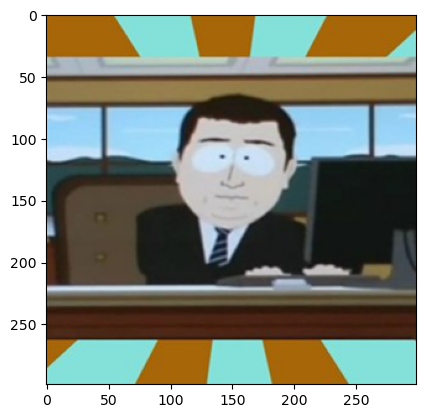

Caption 1: <start> generation sep the baby boomers cheated you out of billions and billions of dollars <end> <pad> <pad> <pad> <pad> <pad>
Caption 2: <start> happy birth day daniel sep welcome to the dirty club <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 3: <start> going to need you to take your opinion sep and shove it waaay up inside your butthole <end> <pad> <pad>
Caption 4: <start> cnn news sep finally respected journalist <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 5: <start> happy birthday sep gypsy bitch <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


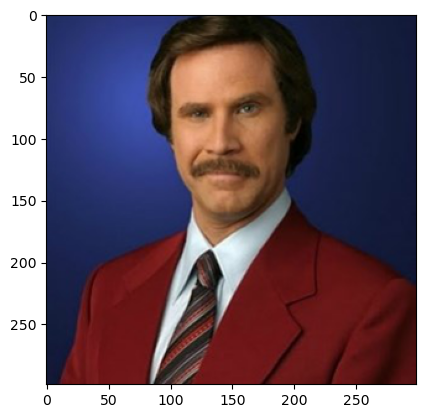

Caption 1: <start> has kid sep every single picture and status for the rest of her life is about having kid <end> <pad>
Caption 2: <start> invites you to be her friend sep never speaks to you <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 3: <start> makes profile picture sep omg am such good person <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 4: <start> has few drinks sep mis spells facebook status on purpose <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 5: <start> likes god on facebook sep omg such good christian <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


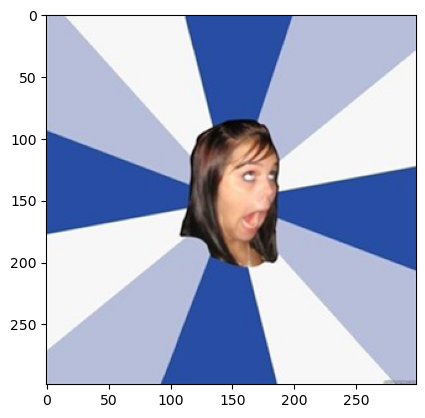

Caption 1: <start> sep dude it dead mau five <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 2: <start> smokes weed and listens to dark side of the moon sep on shuffle <end> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 3: <start> scarface poster or bob marley poster sep decisions <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 4: <start> dj at party sep plays cd then just sits there <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 5: <start> lets drink tonight sep whos got money <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


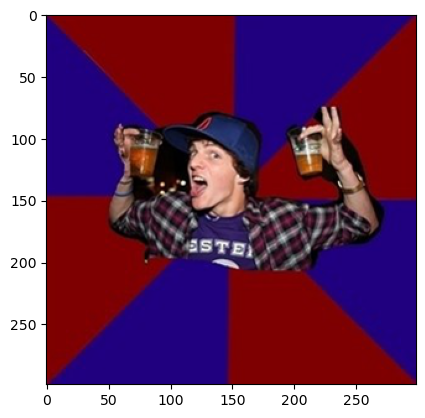

Caption 1: <start> what if oxygen is poisonous sep and takes years to kill us <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 2: <start> what if really am the visitor sep and just missed out on free ipad <end> <pad> <pad> <pad> <pad> <pad>
Caption 3: <start> what if this meme has upvotes sep but the number of downvotes makes it seem really low <end> <pad> <pad>
Caption 4: <start> what if oxygen makes our voice deeper sep and helium brings it back to normal <end> <pad> <pad> <pad> <pad>
Caption 5: <start> what if the reason we have no visitors from the future sep is because we have no future <end> <pad>


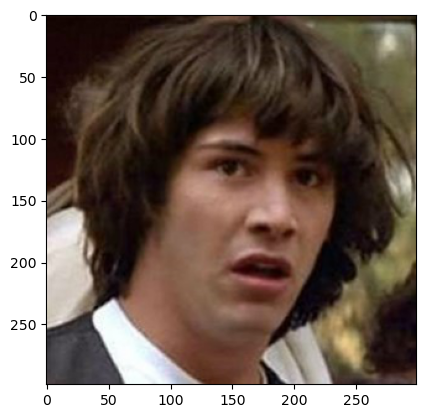

In [5]:
for i in range(5):
    for j in range(5):
        print(f'Caption {j+1}:', ' '.join([idx2word[idx] for idx in train_captions[i * 50 + j]]))
    plt.imshow(train_images[i * 50])
    plt.show()

### Running your RNN model

Depending on your use cases, you may choose to structure your model in a variety of ways. In contrast to previous assignments, this one is intended to mimic a lot of modern research-oriented repositories you might find in the wild. Specifically: **Instead of providing easy-to-use APIs for experimenters, they rigidify their implementation to make tests replicable.** Specifically, they may provide a command-line interface and define testing/training procedures which log results. 

(I mean, ideally you can make a flexible API and allow for both ease of extension and examples to demonstrate how your results were gathered, but sometimes researchers only have so much time...)

Once you have filled in the `model.py` components and the `RNNDecoder` of the `decoder.py` file, run this block to train your RNN model. As you can see, the hyperparamets default to the ones you use in `assignment.py`'s argparse specification, but feel free to change any of them to try to improve your model. 




In [8]:
## TODO: Increase epochs to a larger size when ready (maybe 2 or 3 would be enough?)
!python main.py --type rnn --task train --data ../memes900k/data.p --epochs 10 --chkpt_path ../rnn_model
## if using colab, you may need to do something like the following or might need to %cd into the directory of interest first...

Found 400001 word vectors.
Converted 9418 words (536 misses)

[Valid 1/30]	 loss=6.257	 acc: 0.184	 perp: 521.832
[Valid 2/30]	 loss=6.157	 acc: 0.186	 perp: 472.229
[Valid 3/30]	 loss=6.131	 acc: 0.196	 perp: 459.817
[Valid 4/30]	 loss=6.268	 acc: 0.198	 perp: 527.678
[Valid 5/30]	 loss=6.258	 acc: 0.202	 perp: 522.330
[Valid 6/30]	 loss=6.248	 acc: 0.208	 perp: 517.196
[Valid 7/30]	 loss=6.234	 acc: 0.206	 perp: 509.954
[Valid 8/30]	 loss=6.217	 acc: 0.214	 perp: 501.247
[Valid 9/30]	 loss=6.219	 acc: 0.210	 perp: 502.027
[Valid 10/30]	 loss=6.235	 acc: 0.208	 perp: 510.257
[Valid 11/30]	 loss=6.222	 acc: 0.202	 perp: 503.737
[Valid 12/30]	 loss=6.169	 acc: 0.199	 perp: 477.725
[Valid 13/30]	 loss=6.179	 acc: 0.198	 perp: 482.492
[Valid 14/30]	 loss=6.222	 acc: 0.198	 perp: 503.911
[Valid 15/30]	 loss=6.199	 acc: 0.197	 perp: 492.102
[Valid 16/30]	 loss=6.188	 acc: 0.196	 perp: 486.928
[Valid 17/30]	 loss=6.177	 acc: 0.193	 perp: 481.588
[Valid 18/30]	 loss=6.177	 acc: 0.196	 perp: 4

2024-05-04 19:23:47.218003: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.

2024-05-04 19:24:44.124212: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE SSE2 SSE3 SSE4.1 SSE4.2 AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.




### Running your Transformer model

Once you have completed the `transformer.py` file, run this block to train your transformer based model. Note that running with the `both` task will both train, save, and test your model in one go.

In [6]:
## TODO: Increase epochs to a larger size when ready (maybe 2 or 3 would be enough?)
!python main.py --type transformer --task train --data ../memes900k/data.p --epochs 10 --lr 0.0005 --chkpt_path ../transform_model

Found 400001 word vectors.
Converted 9418 words (536 misses)

[Valid 1/30]	 loss=6.338	 acc: 0.149	 perp: 565.564
[Valid 2/30]	 loss=6.226	 acc: 0.151	 perp: 505.972
[Valid 3/30]	 loss=6.206	 acc: 0.158	 perp: 495.629
[Valid 4/30]	 loss=6.332	 acc: 0.152	 perp: 562.180
[Valid 5/30]	 loss=6.325	 acc: 0.158	 perp: 558.090
[Valid 6/30]	 loss=6.312	 acc: 0.161	 perp: 551.151
[Valid 7/30]	 loss=6.299	 acc: 0.160	 perp: 544.036
[Valid 8/30]	 loss=6.295	 acc: 0.166	 perp: 542.107
[Valid 9/30]	 loss=6.305	 acc: 0.162	 perp: 547.436
[Valid 10/30]	 loss=6.320	 acc: 0.161	 perp: 555.683
[Valid 11/30]	 loss=6.307	 acc: 0.154	 perp: 548.625
[Valid 12/30]	 loss=6.252	 acc: 0.153	 perp: 519.277
[Valid 13/30]	 loss=6.263	 acc: 0.153	 perp: 524.538
[Valid 14/30]	 loss=6.302	 acc: 0.153	 perp: 545.494
[Valid 15/30]	 loss=6.281	 acc: 0.152	 perp: 534.268
[Valid 16/30]	 loss=6.272	 acc: 0.151	 perp: 529.755
[Valid 17/30]	 loss=6.260	 acc: 0.149	 perp: 523.227
[Valid 18/30]	 loss=6.260	 acc: 0.151	 perp: 5

2024-05-05 09:24:10.665331: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.

2024-05-05 09:25:29.079976: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE SSE2 SSE3 SSE4.1 SSE4.2 AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.





## Visualization

After training our Transformer model, you can visualize the self-attention layer to examine the behavior of your attention heads and see if any patterns emerge. 

To test out the components of the model interactively, you'll need to deconstruct selections of the model/runner code and get an instance of the model in an interactive context (aka inside the notebook). 



In [7]:
## Feel free to insert auto-reloads as necessary
from main import parse_args, load_model
from decoder import TransformerDecoder, RNNDecoder

## Pull your model into the notebook. This is heavily based off of assignment.py, 
## and feel free to reuse as much as you want. Your final project will probably 
## involve a lot of this investigative reverse-engineering based on what repos 
## you have to stumble upon.
## You're not in a notebook scenario, so use get_default_arguments and feel free to update it...

args = parse_args('--type rnn --task both --data ../memes900k/data.p'.split())

args.chkpt_path = '../transform_model'
tra_imcap = load_model(args)

args.chkpt_path = '../rnn_model'
rnn_imcap = load_model(args)





Model loaded from '../transform_model'
Model loaded from '../rnn_model'


In [8]:
rnn_imcap.summary()

Model: "image_caption_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn_decoder (RNNDecoder)    multiple                  7318254   
                                                                 
Total params: 7318254 (27.92 MB)
Trainable params: 7318254 (27.92 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
tra_imcap.summary()

Model: "image_caption_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer_decoder (Trans  multiple                  7408554   
 formerDecoder)                                                  
                                                                 
Total params: 7408554 (28.26 MB)
Trainable params: 7408554 (28.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Caption Generation
Now that you have trained both of your models, it's time to use them to generate original captions for images in the testing set. First, the model is given the <start\> token and asked to generate probabilites for the next word in the sequence. The next token is chosen by sampling from that probability. This process repeats until the model generates the <end\> token, or the maximum sequence length is reached.

 



There is still one piece of this equation missing. The tokens are sampled from the probabilities your models generate, but your models were required to output logits, not probabilities. This is becasue this assignment, like many NLP models, uses temperature as a parameter in text generation. If the models sampled from  probabilies calculated by simply applying softmax to the logits, then the probability of the most likely word will usually be very high and the models will usually genrate the same, most probable caption every time. We use the temperature as a parameter to even out the probabilites so the model produces more 'creative' captions. This is done by dividing the logits by the temperature parameter before applying softmax. Higher temprature values will give a more creative captiong, while temprature values closer to 0 will be more greedy. Check out [this](https://lukesalamone.github.io/posts/what-is-temperature/) article for a demonstration and further explaination of temprature in NLP models.


In [10]:
def gen_caption_temperature(model, image_embedding, wordToIds, padID, temp, window_length):
    """
    Function used to generate a caption using an ImageCaptionModel given
    an image embedding. 
    """
    idsToWords = {id: word for word, id in wordToIds.items()}
    unk_token = wordToIds['<unk>']
    caption_so_far = [wordToIds['<start>']]
    while len(caption_so_far) < window_length and caption_so_far[-1] != wordToIds['<end>']:
        caption_input = np.array([caption_so_far + ((window_length - len(caption_so_far)) * [padID])])
        logits = model(np.expand_dims(image_embedding, 0), caption_input)
        logits = logits[0][len(caption_so_far) - 1]
        probs = tf.nn.softmax(logits / temp).numpy()
        next_token = unk_token
        attempts = 0
        while next_token == unk_token and attempts < 5:
            next_token = np.random.choice(len(probs), p=probs)
            attempts += 1
        caption_so_far.append(next_token)
    return ' '.join([idsToWords[x] for x in caption_so_far][1:-1])

## Generating Sentences for Training Data 

C1: did not hear your question sep but the answer is aliens
C2: just took dump sep this big
C3: don know sep therefore aliens
C4: what my favorite movie sep aliens
C5: gravity sep no alien conspiracy to keep us on our own planet
RNN: not sure if you re not sep the only one more time
TRA: if you sep it


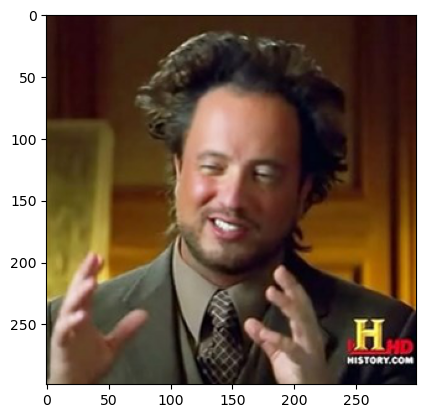

C1: so you telling me sep you need computer to play minesweeper
C2: so you re telling me that sep facebook likes are gonna somehow feed me
C3: you mean to tell me sep you shit in perfectly clean water
C4: so your telling me you wash your plates with clean water sep because theres still food on them
C5: your sep are you immortal
RNN: so you re telling me sep you re gonna have bad time
TRA: so you re telling me sep you mean to tell me


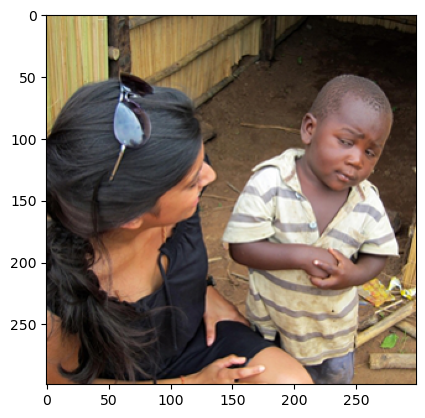

C1: if you re trying to explain meme sep you re gonna have bad time
C2: if you expect the oscar to be fair sep you re gonna have bad time
C3: if you go to memegenerator to find funny meme sep you re gonna have bad time
C4: if you start your research paper the night before it due sep you re gonna have bad time
C5: if you just started test and have to pee sep you re gonna have bad time
RNN: if you re gonna have you re gonna have bad time sep that would be great
TRA: if you have bad time sep you re gonna have bad time


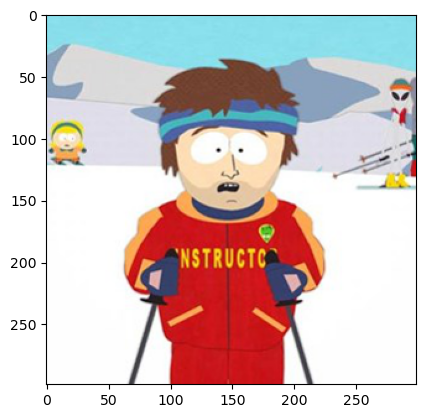

C1: geek loser in high school sep sex god in college
C2: watch sports sep root for team with better logo
C3: professor compares your work to an artist you ve never heard of sep go home google them cry
C4: mix the perfect shade of certain color sep always run out halfway through painting
C5: creative burst in the middle of night sep get more done within an hour than you get on day
RNN: the fuck sep is the best can do
TRA: you know sep never go to capture it


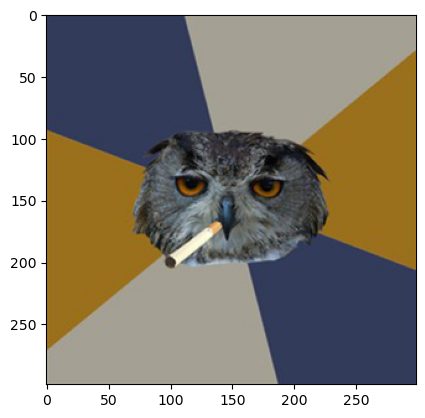

C1: know you re studying now sep so ll visit you after exams
C2: hey girl sep tell your husband to hire me as your pool boy ll keep it wet
C3: really wanted to be with lynda sep but forgot to pull out of eva
C4: go fuck yourself sep memegenerator
C5: hey girl miles ain sep got nothin on you
RNN: hey girl sep you re gonna have no power here
TRA: hey girl sep you re sexier


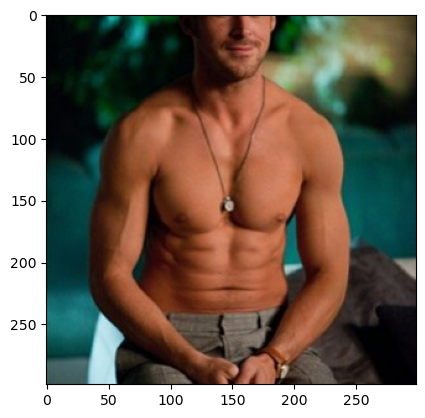

C1: ll just play for few minutes before going to bed sep aaaand it dawn
C2: had chance to win sep aaannd it gone
C3: weekend just started sep aaaaand it gone
C4: finally in relationship with the person you love sep aaaaaand its gone
C5: poops reaches for toilet paper sep aaaaand it gone
RNN: you re gonna have my own sep with blackjack and hookers
TRA: had chance to the lead sep aaaaand it gone


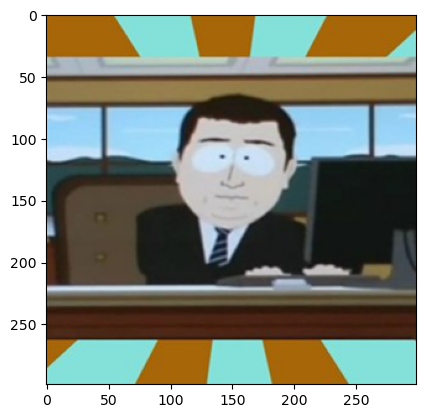

C1: phone goes of at funeral sep ringtone is highway to hell
C2: wins lottery sep loses ticket
C3: want to sep lay down ryan
C4: plays airsoft sep dies
C5: looks on the bright side sep turns blind
RNN: goes to the world sep still not impressed
TRA: watches yaoi sep gets herpes


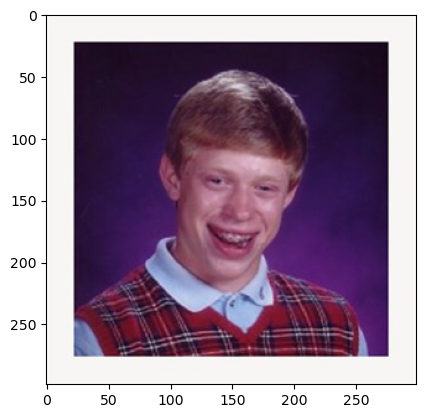

C1: body sep positivity
C2: models don represent real women sep in america
C3: immigrant sep so this is america huh
C4: getting dressed sep for dinner
C5: junk food sep fast food very fast food
RNN: emp sep no one
TRA: models sep fuck


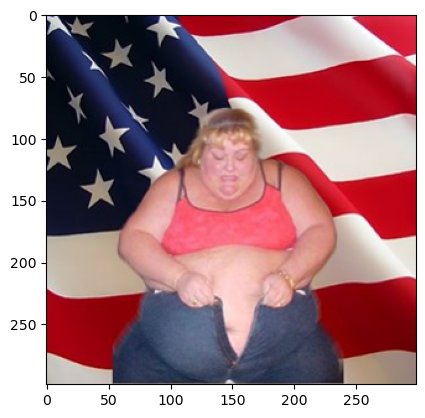

C1: trees sep they re just really really slow explosions
C2: when life gives you lemons sep have no idea where am right now
C3: how high are you sep yes
C4: cop says how high are you sep so say no its hi how are you
C5: get stoned sep watch bob ross paint
RNN: if you re talking about you sep that be great
TRA: giraffe giraffe giraffe giraffe giraffe giraffe giraffe giraffe giraffe giraffe giraffe giraffe giraffe giraffe giraffe giraffe giraffe giraffe


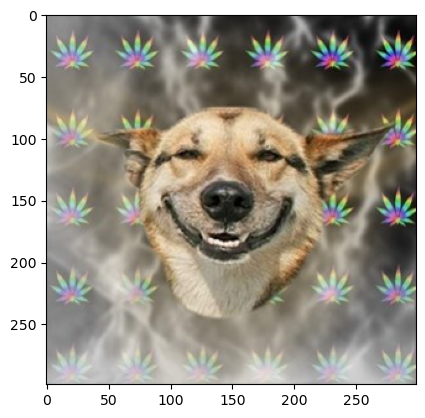

C1: what crazy day sep only hours of sleep
C2: increase profit margins sep you gotta be kitten me
C3: jenkins this report is unacceptable sep afraid ll have to get the spray bottle
C4: ups brought an empty box sep cancel my clock
C5: what do you mean sep you only live once
RNN: you re gonna have my own sep with blackjack and hookers
TRA: clawed sep need to get some catnip


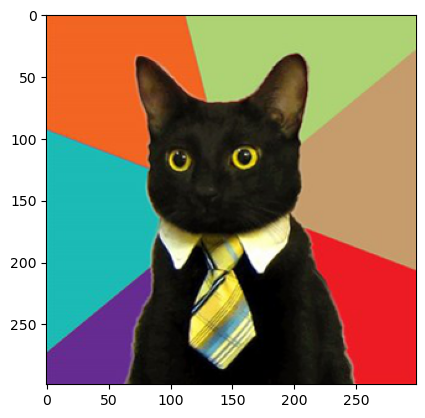

In [13]:
temperature = 0.1
indices = np.random.choice(np.array(list(range(0, 5000, 50))), 10, replace=False)
for i in indices:
    curr_image_feat = train_img_feats[i]
    curr_image      = train_images[i]
    for j in range(5):  ## Display all of the captions trained on
        words = [idx2word[x] for x in train_captions[i+j][:-1] if idx2word[x] not in ('<pad>', '<start>', '<end>')]
        print(f'C{j+1}:', ' '.join(words))
    print('RNN:', gen_caption_temperature(rnn_imcap, curr_image_feat, word2idx, word2idx['<pad>'], temperature, args.window_size))
    print('TRA:', gen_caption_temperature(tra_imcap, curr_image_feat, word2idx, word2idx['<pad>'], temperature, args.window_size))
    plt.imshow(curr_image)
    plt.show()

### Trying out on things in testing set!

295


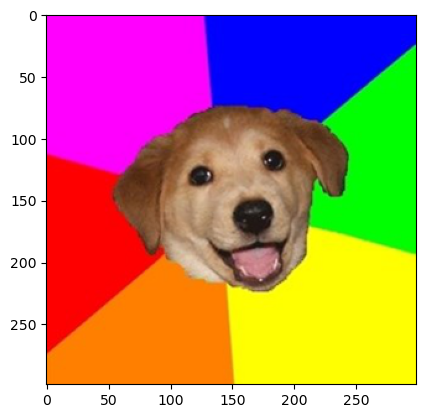

170


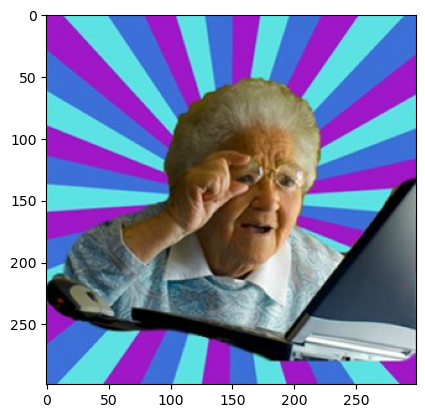

55


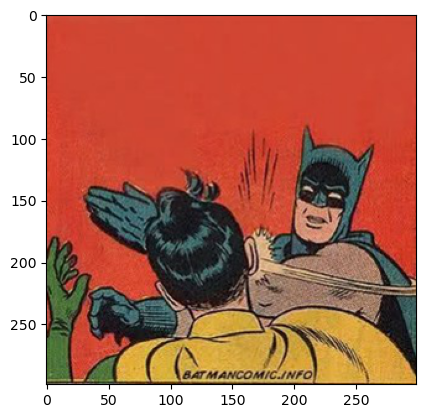

175


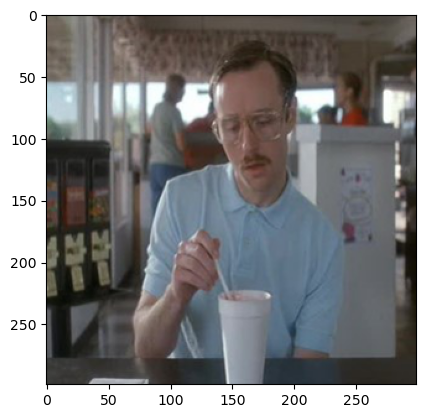

190


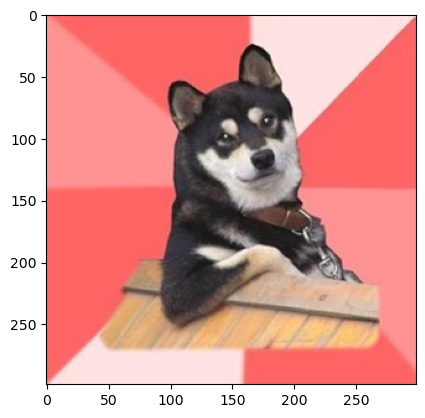

10


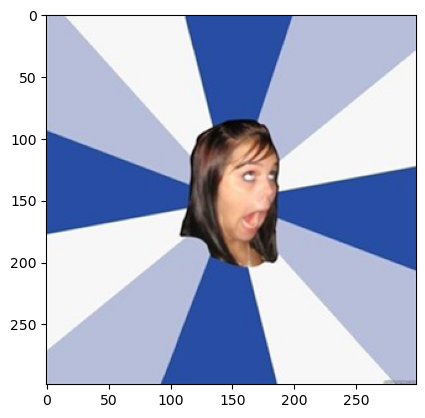

340


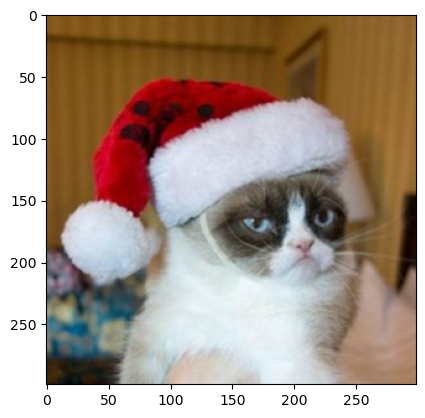

305


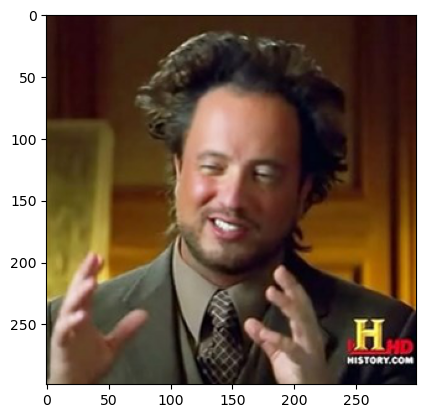

385


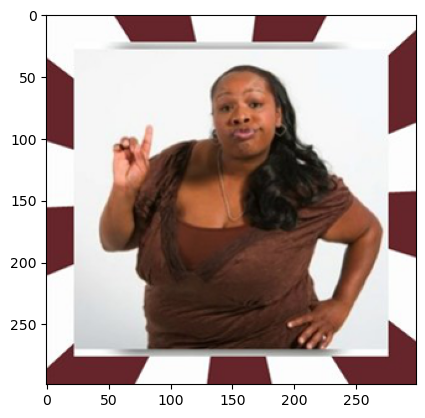

315


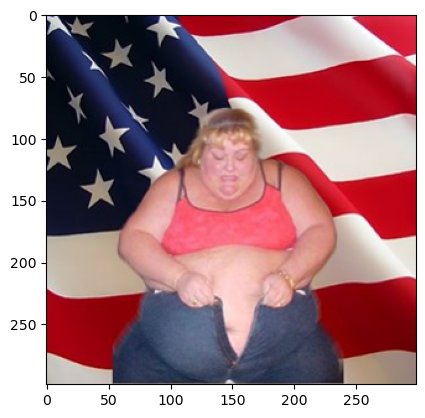

In [14]:
temperature = 0.2
indices = np.random.choice(np.array(list(range(0, 500, 5))), 10, replace=False)
rnn_captions = []
tra_captions = []

import warnings
warnings.filterwarnings("ignore", message=".*All model checkpoint layers were used.*")

for i in indices:
    print(i)
    curr_image_feat = train_img_feats[i]
    curr_image      = train_images[i]
    rnn_caption = gen_caption_temperature(rnn_imcap, curr_image_feat, word2idx, word2idx['<pad>'], temperature, args.window_size)
    tra_caption = gen_caption_temperature(tra_imcap, curr_image_feat, word2idx, word2idx['<pad>'], temperature, args.window_size)
    rnn_captions.append(rnn_caption)
    tra_captions.append(tra_caption)
    #output = rnn_imcap.get_offensive_score("Here")
    #text, offensive_score = rnn_imcap.get_unfiltered_captions(curr_image_feat, word2idx, word2idx['<pad>'], args.window_size)
    #print(text, "Offensive score: ", offensive_score)
    plt.imshow(curr_image)
    plt.show()

In [35]:
from filter_utils import print_captions_and_label
print_captions_and_label(tra_captions, "offensive")

#print_captions_and_label(["happy birthday sep you magnificent beast"], "offensive")

yes sep yes
1) not-offensive 0.8003
2) offensive 0.1997

goes to resturant sep still consider
1) not-offensive 0.8626
2) offensive 0.1374

you like this sep you
1) not-offensive 0.8622
2) offensive 0.1378

just got it sep aaaaand it gone
1) not-offensive 0.7854
2) offensive 0.2146

what if told you sep the heck is the ultimate
1) offensive 0.6173
2) not-offensive 0.3827

what if you sep and the downvotes sep and what if you have no one
1) not-offensive 0.8805
2) offensive 0.1195

happy birthday sep you stay classy
1) not-offensive 0.8751
2) offensive 0.1249

you have no power here sep you have no power here
1) not-offensive 0.8222
2) offensive 0.1778

happy birthday sep you re kind of beard
1) not-offensive 0.7301
2) offensive 0.2699

what if you sep and kill yourself
1) offensive 0.644
2) not-offensive 0.356



In [31]:
indices = np.random.choice(np.array(list(range(0, 5000, 50))), 20, replace=False)

import warnings
warnings.filterwarnings("ignore", message=".*All model checkpoint layers were used.*")

unfiltered_offensive_score = []
average_filtered = []
filtered_offensive_score = []
average_unfiltered = []

for i in indices:
    print(i)
    curr_image_feat = train_img_feats[i]
    curr_image      = train_images[i]
    text1, offensive_score_un = tra_imcap.get_unfiltered_captions(curr_image_feat, word2idx, word2idx['<pad>'], args.window_size)
    unfiltered_offensive_score.append({text1, offensive_score_un})
    average_unfiltered.append(offensive_score_un)
    text2, offensive_score = tra_imcap.get_filtered_captions(curr_image_feat, word2idx, word2idx['<pad>'], args.window_size)
    filtered_offensive_score.append({text2, offensive_score})
    average_filtered.append(offensive_score)
    plt.imshow(curr_image)
    plt.show()


400


RuntimeError: Can't decrement id ref count (unable to extend file properly)

In [28]:
print("filtered offensive scores", average_filtered)
print("unfilted offensive scores", average_unfiltered)
print("filtered offensive score average: ", tf.reduce_sum(average_filtered) / 20.0)
print("unfilted offensive score average: ", tf.reduce_sum(average_unfiltered) / 20.0)

filtered offensive scores [0.13431914, 0.2020421, 0.23806316, 0.08363802, 0.28519043, 0.20654696, 0.230759, 0.17832066, 0.06495322, 0.21881613, 0.101023324, 0.21931276, 0.11239971, 0.059044562, 0.14718102, 0.22256473, 0.2581137, 0.08580892, 0.19902472, 0.1969396]
unfilted offensive scores [0.20316644, 0.24832426, 0.08989793, 0.08883349, 0.28519043, 0.23808157, 0.12934612, 0.17832066, 0.29675415, 0.10920062, 0.1156066, 0.081774645, 0.11239971, 0.087069236, 0.78635067, 0.22971396, 0.26385128, 0.18269753, 0.14990738, 0.1969396]
filtered offensive score average:  tf.Tensor(0.1722031, shape=(), dtype=float32)
unfilted offensive score average:  tf.Tensor(0.2036713, shape=(), dtype=float32)


In [30]:
for i in range(0, 20):
    print(unfiltered_offensive_score[i], filtered_offensive_score[i])

{0.20316644, 'have no one does it sep no one'} {0.13431914, 'have no one more time sep emp'}
{0.24832426, 'so you re sep and then ll give you re gonna have no one'} {0.2020421, 'so you re the world sep and then ll give you re gonna have no one'}
{0.08989793, 'hey girl sep good luck with my favorite'} {0.23806316, 'hey girl sep don like mowing'}
{0.08883349, 'what if told you sep you can do you'} {0.08363802, 'what if told you sep you have to the best can be democratically'}
{0.28519043, 'emp sep micah'} {0.28519043, 'emp sep micah'}
{0.23808157, 'oh you mean sep you'} {0.20654696, 'you mean sep you'}
{'why are you re going to be sep but when they re', 0.12934612} {0.230759, 'hey girl sep don like it'}
{0.17832066, 'you sep emp'} {0.17832066, 'you sep emp'}
{0.29675415, 'if you have sep you have bad time'} {'if you have sep and will be going to the world', 0.06495322}
{0.10920062, 'you know sep you'} {0.21881613, 'if you don know sep you'}
{0.1156066, 'so you re sep and will be like'} {

In [2]:
!rm -rf cardiffnlp